# Optical pumping in a magnetic field

This script checks the rotations in the OBEs by optically pumping with circular polarized
light along all three axes and seeing if it pumps to the appropriate spin state
along those axes.  It compares these to direct integration of the Schrodinger equation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from scipy.integrate import solve_ivp
from pylcp.common import spherical2cart

transform = False # Change the variable to transform OBEs into re/im components.

### Define the problem

In [2]:
# Which polarization do we want?
pol = +1

# First, create the laser beams:
laserBeams = {}
laserBeams['x']= pylcp.laserBeams(
    [{'kvec': np.array([1., 0., 0.]), 'pol':pol, 'delta':0., 'beta':2.0}],
    beam_type=pylcp.infinitePlaneWaveBeam
    )
laserBeams['y']= pylcp.laserBeams(
    [{'kvec': np.array([0., 1., 0.]), 'pol':pol, 'delta':0., 'beta':2.0}],
    beam_type=pylcp.infinitePlaneWaveBeam
    )
laserBeams['z']= pylcp.laserBeams(
    [{'kvec': np.array([0., 0., 1.]), 'pol':pol, 'delta':0., 'beta':2.0}],
    beam_type=pylcp.infinitePlaneWaveBeam
    )

# For making the Hamiltonian
E={}
for key in laserBeams:
    E[key] = laserBeams[key].cartesian_pol()[0]

# Then the magnetic field:
magField = lambda R: np.zeros(R.shape)
gF=1

# Hamiltonian for F=0->F=1
Hg, mugq, basis_g = pylcp.hamiltonians.singleF(F=0, gF=gF, muB=1, return_basis=True)
He, mueq, basis_e = pylcp.hamiltonians.singleF(F=1, gF=gF, muB=1, return_basis=True)
d_q = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mueq, d_q)
laserBeams['x'].total_electric_field(np.array([0., 0., 0.]), 0.)
obe = {}

basis =np.concatenate((basis_g, basis_e))

### Let's start with no magnetic field

We will do this by constructing the full Hamiltonian in three different ways, and makes sure they are all equal.  It then integrates the Schrodinger equation and then compares to the OBEs integrated without decays (should be equivalent).

True True
True True


/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


True True


/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substitutin

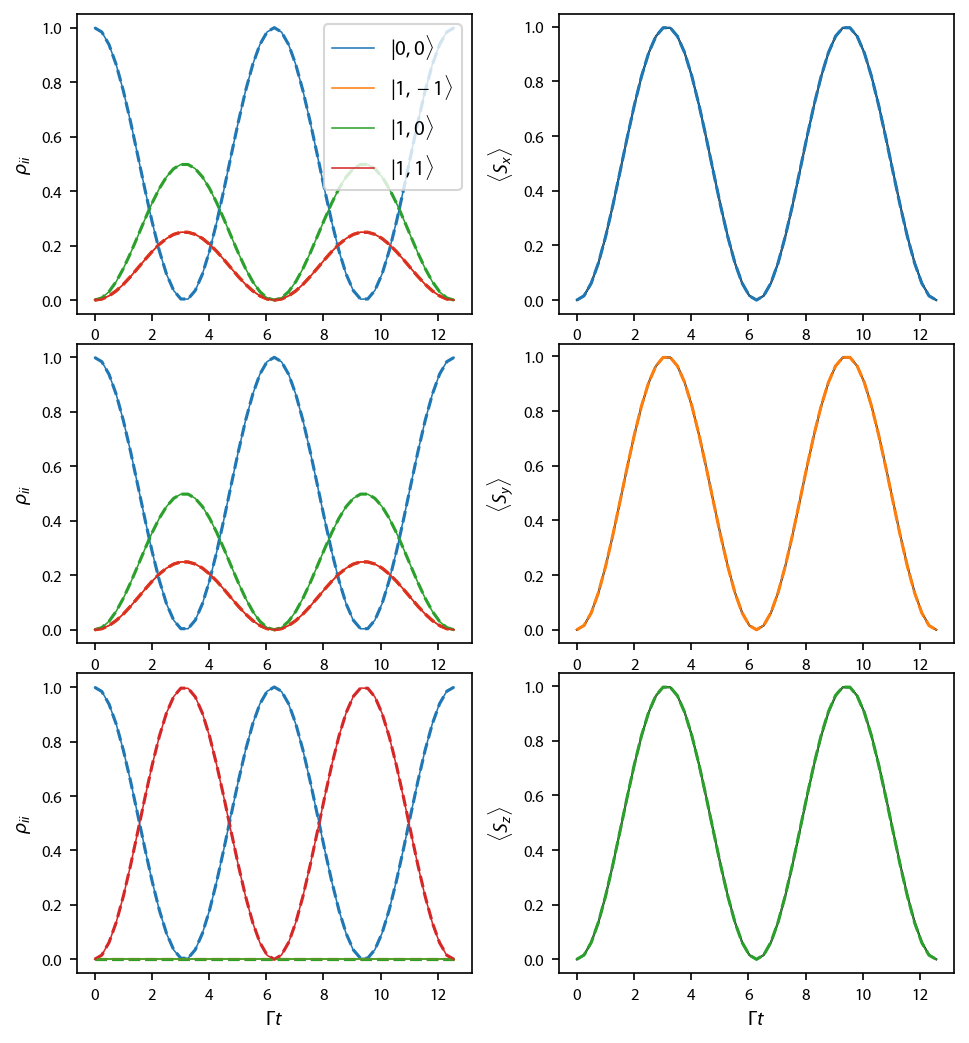

In [3]:
# Excited state spin observable.  The spin is not along the magnetic moment:
S_ex = -spherical2cart(mueq)/gF
S = np.zeros((3, hamiltonian.n, hamiltonian.n), dtype='complex128')
S[:, 1:, 1:] = S_ex

# Make a figure
fig, ax = plt.subplots(3, 2, figsize=(6.5, 2.5*2.75))
for ii, key in enumerate(laserBeams):
    # In this loop, we will make the
    ax[ii, 1].plot(np.linspace(0, 4*np.pi, 51),
                   pol*(1-np.cos(np.linspace(0, 4*np.pi, 51)))/2, 'k-',
                   linewidth=1)
    d = spherical2cart(d_q)
    H_sub = -0.5*np.tensordot(d, E[key], axes=(0, 0))

    H = np.zeros((4, 4)).astype('complex128')
    H[0, 1:] = H_sub
    H[1:, 0] = np.conjugate(H_sub)

    H_sub2 = np.zeros(d_q[0].shape).astype('complex128')
    for kk, q in enumerate(np.arange(-1, 2, 1)):
        H_sub2 -= 0.5*(-1.)**q*d_q[kk]*laserBeams[key].beam_vector[0].pol()[2-kk]

    H2 = np.zeros((4, 4)).astype('complex128')
    H2[0, 1:] = H_sub2
    H2[1:, 0] = np.conjugate(H_sub2)

    H3 = hamiltonian.return_full_H({'g->e': laserBeams[key].beam_vector[0].pol()},
                                   np.zeros((3,)).astype('complex128'))
    psi0 = np.zeros((4,)).astype('complex128')
    psi0[0] = 1.
    sol = solve_ivp(lambda t, x: -1j*H2 @ x, [0, 4*np.pi], psi0,
                    t_eval=np.linspace(0, 4*np.pi, 51))

    print(np.allclose(H, H2), np.allclose(H, H3))

    S_av = np.zeros(sol.t.shape)
    for jj in range(sol.t.size):
        S_av[jj] = np.conjugate(sol.y[1:, jj])@S_ex[ii]@sol.y[1:, jj]

    for jj in range(4):
        ax[ii, 0].plot(sol.t, np.abs(sol.y[jj, :])**2, '--', color='C%d'%jj)

    ax[ii, 1].plot(sol.t, S_av, '--', color='C%d'%ii)

    obe[key] = pylcp.obe(laserBeams[key], magField, hamiltonian,
                         transform_into_re_im=transform)
    rho0 = np.zeros((16,))
    rho0[0] = 1 # Always start in the ground state.

    obe[key].ev_mat['decay'][:, :] = 0. # Forcibly turn off decay, make it like S.E.
    obe[key].set_initial_rho(rho0)
    obe[key].evolve_density(t_span=[0, 2*np.pi*2], t_eval=np.linspace(0, 4*np.pi, 51))
    S_av = obe[key].observable(S[ii])

    for jj in range(4):
        ax[ii, 0].plot(obe[key].sol.t, np.real(obe[key].sol.rho[jj, jj]), linewidth=0.75, color='C%d'%jj,
                       label='$|%d,%d\\rangle$'%(basis[jj, 0], basis[jj, 1]))
    ax[ii, 0].set_ylabel('$\\rho_{ii}$')

    ax[ii, 1].plot(obe[key].sol.t, S_av, color='C%d'%ii, linewidth=0.75)
    ax[ii, 1].set_ylabel('$\\langle S_%s\\rangle$'%key)

[ax[-1, jj].set_xlabel('$\Gamma t$') for jj in range(2)]
ax[0, 0].legend()
fig.subplots_adjust(left=0.08, bottom=0.05, wspace=0.22)

Dashed curves are integration of the Hamiltonian through the Schrodinger equation, and the solid curves are the OBEs.

### Next, let's apply a magnetic field

And see if we can tune the lasers into
resonance.  This will check to make sure that we have the detunings right.

With $g_F>0$, the shift for $+m_F$ is upwards, requiring a blue-shift on the
lasers (or, equivalently, the Hamiltonian) to compensate.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


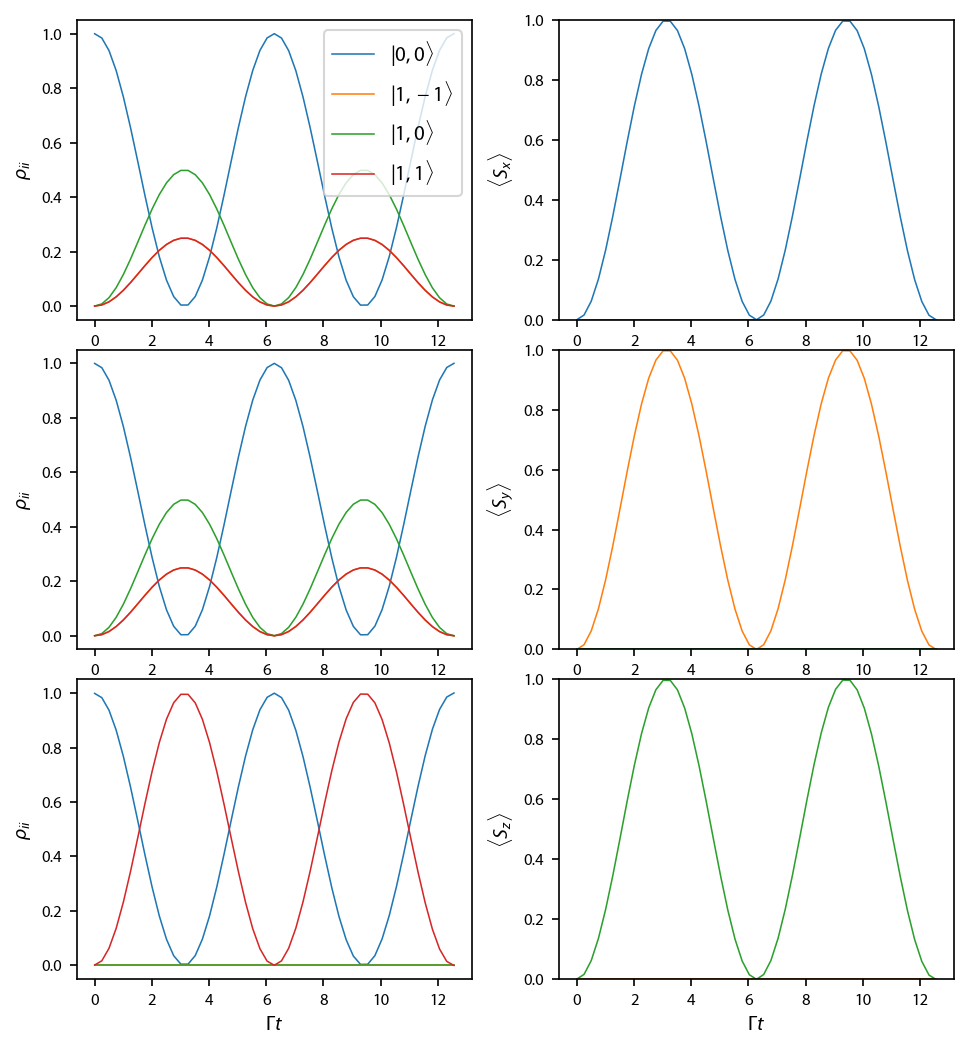

In [4]:
magField = {}
magField['x'] = lambda R: np.array([-1., 0., 0.])
magField['y'] = lambda R: np.array([0., -1., 0.])
magField['z'] = lambda R: np.array([0., 0., -1.])

pol=+1
laser_det=-0.5
ham_det=-0.5
laserBeams = {}
laserBeams['x']= pylcp.laserBeams([
    {'kvec': np.array([1., 0., 0.]), 'pol':pol, 'delta':laser_det, 'beta':2.0}
    ])
laserBeams['y']= pylcp.laserBeams([
    {'kvec': np.array([0., 1., 0.]), 'pol':pol, 'delta':laser_det, 'beta':2.0}
    ])
laserBeams['z']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':pol, 'delta':laser_det, 'beta':2.0}
    ])

hamiltonian = pylcp.hamiltonian(Hg, He-ham_det*np.eye(3), mugq, mueq, d_q)

fig, ax = plt.subplots(3, 2, figsize=(6.5, 2.5*2.75))
for ii, key in enumerate(laserBeams):
    obe[key] = pylcp.obe(laserBeams[key], magField[key], hamiltonian,
                         transform_into_re_im=transform)
    rho0 = np.zeros((16,))
    rho0[0] = 1 # Always start in the ground state.

    obe[key].ev_mat['decay'][:, :] = 0. # Forcibly turn off decay, make it like S.E.
    obe[key].set_initial_rho(rho0)
    obe[key].evolve_density(t_span=[0, 2*np.pi*2], t_eval=np.linspace(0, 4*np.pi, 51))

    for jj in range(4):
        ax[ii, 0].plot(obe[key].sol.t,
                       np.real(obe[key].sol.rho[jj, jj]),
                       linewidth=0.75, color='C%d'%jj,
                       label='$|%d,%d\\rangle$'%(basis[jj, 0], basis[jj, 1]))
    ax[ii, 0].set_ylabel('$\\rho_{ii}$')

    S_av = obe[key].observable(S)

    ax[ii, 1].plot(obe[key].sol.t, S_av.T, linewidth=0.75)
    ax[ii, 1].set_ylabel('$\\langle S_%s\\rangle$'%key)
    ax[ii, 1].set_ylim((0, 1))

[ax[-1, jj].set_xlabel('$\Gamma t$') for jj in range(2)]
ax[0, 0].legend()
fig.subplots_adjust(left=0.08, bottom=0.05, wspace=0.22)

### Finally, let's switch to some different polarization along $z$:

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


True True
True True


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


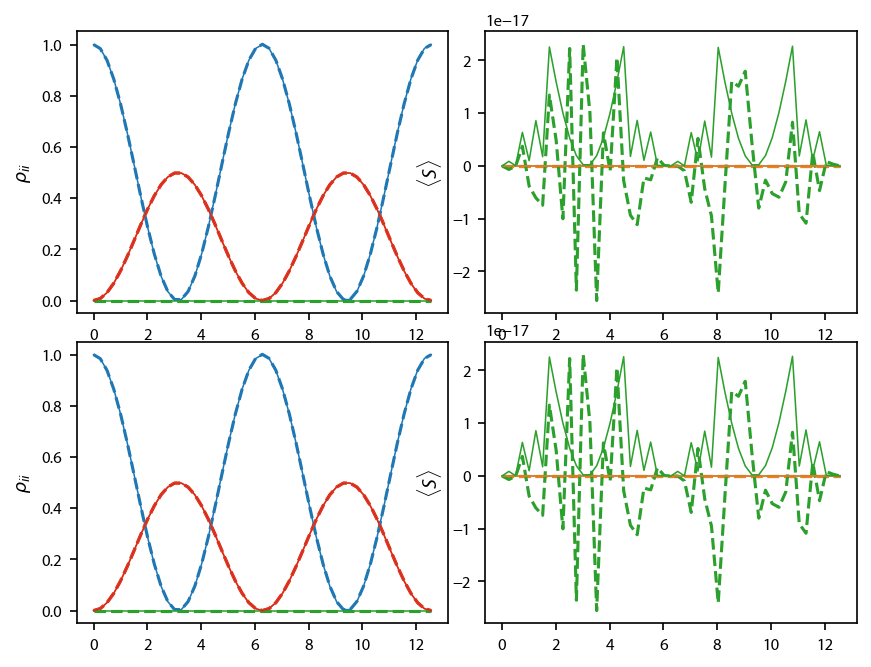

In [5]:
# Which polarization do we want?
pol = +1
ham_det = 0.

# First, create the laser beams:
laserBeams['$\\pi_x$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([1., 0., 0.]),
     'pol_coord':'cartesian', 'delta':0., 'beta':2.0}
    ])
laserBeams['$\\pi_y$']= pylcp.laserBeams([
    {'kvec': np.array([0., 0., 1.]), 'pol':np.array([0., 1., 0.]),
     'pol_coord':'cartesian', 'delta':0., 'beta':2.0}
    ])

hamiltonian = pylcp.hamiltonian(Hg, He-ham_det*np.eye(3), mugq, mueq, d_q)
magField = lambda R: np.array([0., 0., 0.])

fig, ax = plt.subplots(2, 2, figsize=(6.5, 1.75*2.75))
for ii, key in enumerate(['$\\pi_x$', '$\\pi_y$']):
    d = spherical2cart(d_q)
    E = spherical2cart(laserBeams[key].beam_vector[0].pol())

    H_sub = -0.5*np.tensordot(d, E, axes=(0, 0))

    H = np.zeros((4, 4)).astype('complex128')
    H[0, 1:] = H_sub
    H[1:, 0] = np.conjugate(H_sub)

    H_sub2 = np.zeros(d_q[0].shape).astype('complex128')
    for kk, q in enumerate(np.arange(-1, 2, 1)):
        H_sub2 -= 0.5*(-1.)**q*d_q[kk]*laserBeams[key].beam_vector[0].pol()[2-kk]

    H2 = np.zeros((4, 4)).astype('complex128')
    H2[0, 1:] = H_sub2
    H2[1:, 0] = np.conjugate(H_sub2)

    H3 = hamiltonian.return_full_H({'g->e': laserBeams[key].beam_vector[0].pol()},
                                   np.zeros((3,)).astype('complex128'))

    psi0 = np.zeros((4,)).astype('complex128')
    psi0[0] = 1.
    sol = solve_ivp(lambda t, x: -1j*H @ x, [0, 4*np.pi], psi0, t_eval=np.linspace(0, 4*np.pi, 51))

    print(np.allclose(H, H2), np.allclose(H, H3))

    S_av = np.zeros((3,)+ sol.t.shape)
    for jj in range(3):
        for kk in range(sol.t.size):
            S_av[jj, kk] = np.conjugate(sol.y[1:, kk])@S_ex[jj]@sol.y[1:, kk]

    for jj in range(4):
        ax[ii, 0].plot(sol.t, np.abs(sol.y[jj, :])**2, '--', color='C%d'%jj)

    for jj in range(3):
        ax[ii, 1].plot(sol.t, S_av[jj], '--', color='C%d'%jj)

    obe[key] = pylcp.obe(laserBeams[key], magField, hamiltonian, transform_into_re_im=transform)
    rho0 = np.zeros((16,))
    rho0[0] = 1 # Always start in the ground state.

    obe[key].ev_mat['decay'][:, :] = 0. # Forcibly turn off decay, make it like S.E.
    obe[key].set_initial_rho(rho0)
    obe[key].evolve_density(t_span=[0, 2*np.pi*2], t_eval=np.linspace(0, 4*np.pi, 51))
    S_av = obe[key].observable(S)

    for jj in range(4):
        ax[ii, 0].plot(obe[key].sol.t,
                       np.real(obe[key].sol.rho[jj, jj]),
                       linewidth=0.75, color='C%d'%jj,
                       label='$|%d,%d\\rangle$'%(basis[jj, 0], basis[jj, 1]))
    ax[ii, 0].set_ylabel('$\\rho_{ii}$')

    [ax[ii, 1].plot(obe[key].sol.t, S_av[jj], linewidth=0.75, color='C%d'%jj) for jj in range(3)]
    ax[ii, 1].set_ylabel('$\\langle S\\rangle$')